## Soccer Results Prediction - Poisson Model

source: https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from scipy.stats import poisson,skellam

In [2]:
epl_1617 = pd.read_csv("http://www.football-data.co.uk/mmz4281/1617/E0.csv")
epl_1617 = epl_1617[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR']]
epl_1617 = epl_1617.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals' , 'FTR' : 'Winner'})
epl_1617.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Winner
0,Burnley,Swansea,0,1,A
1,Crystal Palace,West Brom,0,1,A
2,Everton,Tottenham,1,1,D
3,Hull,Leicester,2,1,H
4,Man City,Sunderland,2,1,H


We use all the games from season 16/17 until the last 10 games to calculate the average goals of a team and the last 10 games we will try to predict.

In [3]:
epl_1617 = epl_1617[:-10]
epl_1617.mean()

HomeGoals    1.591892
AwayGoals    1.183784
dtype: float64

In [4]:
# probability of draw between home and away team
skellam.pmf(0.0,  epl_1617.mean()[0],  epl_1617.mean()[1])

0.24809376810717076

In [5]:
# probability of home team winning by one goal
skellam.pmf(1,  epl_1617.mean()[0],  epl_1617.mean()[1])

0.22706765807563964

In [6]:
# probability of home team winning by two goals
skellam.pmf(2,  epl_1617.mean()[0],  epl_1617.mean()[1])

0.14180866650031265

Since we are assuming that the number of goals scored by each team are independent events. Therefore, each event has its own Poisson distribution and the difference of two Poisson distributions is a Skellam distribution, which we ae using to model the results in the follwoing cell.

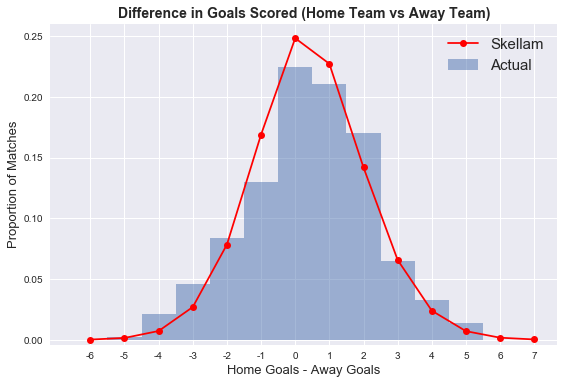

In [7]:
skellam_pred = [skellam.pmf(i,  epl_1617.mean()[0],  epl_1617.mean()[1]) for i in range(-6,8)]

plt.hist(epl_1617[['HomeGoals']].values - epl_1617[['AwayGoals']].values, range(-6,8), 
         alpha=0.5, label='Actual',normed=True)
plt.plot([i+0.5 for i in range(-6,8)], skellam_pred,
                  linestyle='-', marker='o',label="Skellam", color = 'r')
plt.legend(loc='upper right', fontsize=15)
plt.xticks([i+0.5 for i in range(-6,8)],[i for i in range(-6,8)])
plt.xlabel("Home Goals - Away Goals",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Difference in Goals Scored (Home Team vs Away Team)",size=14,fontweight='bold')
plt.ylim([-0.004, 0.26])
plt.tight_layout()
plt.show()

The way this works is the we have to figure out the average goals scored by each team and feed this into the Poisson model. We assume that the number of goals scored by each team is Poisson distributed. To show that we can model the goals scored in season 16/17 by two teams in this case Chelsea and West Brom. We seperate the data into goals scored home and away.

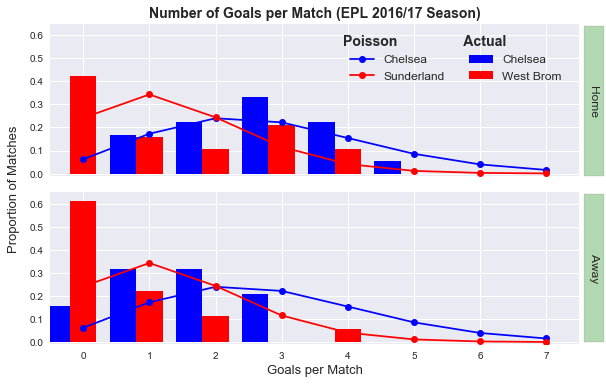

In [8]:
fig,(ax1,ax2) = plt.subplots(2, 1)


chel_home = epl_1617[epl_1617['HomeTeam']=='Chelsea'][['HomeGoals']].apply(pd.value_counts,normalize=True)
chel_home_pois = [poisson.pmf(i,np.sum(np.multiply(chel_home.values.T,chel_home.index.T),axis=1)[0]) for i in range(8)]
sun_home = epl_1617[epl_1617['HomeTeam']=='West Brom'][['HomeGoals']].apply(pd.value_counts,normalize=True)
sun_home_pois = [poisson.pmf(i,np.sum(np.multiply(sun_home.values.T,sun_home.index.T),axis=1)[0]) for i in range(8)]

chel_away = epl_1617[epl_1617['AwayTeam']=='Chelsea'][['AwayGoals']].apply(pd.value_counts,normalize=True)
chel_away_pois = [poisson.pmf(i,np.sum(np.multiply(chel_home.values.T,chel_home.index.T),axis=1)[0]) for i in range(8)]
sun_away = epl_1617[epl_1617['AwayTeam']=='Sunderland'][['AwayGoals']].apply(pd.value_counts,normalize=True)
sun_away_pois = [poisson.pmf(i,np.sum(np.multiply(sun_home.values.T,sun_home.index.T),axis=1)[0]) for i in range(8)]

ax1.bar(chel_home.index-0.4,chel_home.values,width=0.4,color="b",label="Chelsea")
ax1.bar(sun_home.index,sun_home.values,width=0.4,color="r",label="West Brom")
pois1, = ax1.plot([i for i in range(8)], chel_home_pois,
                  linestyle='-', marker='o',label="Chelsea", color = "b")
pois1, = ax1.plot([i for i in range(8)], sun_home_pois,
                  linestyle='-', marker='o',label="Sunderland", color = "r")
leg=ax1.legend(loc='upper right', fontsize=12, ncol=2)
leg.set_title("Poisson                 Actual                ", prop = {'size':'14', 'weight':'bold'})
ax1.set_xlim([-0.5,7.5])
ax1.set_ylim([-0.01,0.65])
ax1.set_xticklabels([])
ax1.text(7.65, 0.585, '                Home                ', rotation=-90,
        bbox={'facecolor':'g', 'alpha':0.3, 'pad':5})
ax2.text(7.65, 0.585, '                Away                ', rotation=-90,
        bbox={'facecolor':'g', 'alpha':0.3, 'pad':5})

ax2.bar(chel_away.index-0.4,chel_away.values,width=0.4,color="b",label="Chelsea")
ax2.bar(sun_away.index,sun_away.values,width=0.4,color="r",label="Sunderland")
pois1, = ax2.plot([i for i in range(8)], chel_away_pois,
                  linestyle='-', marker='o',label="Chelsea", color = "b")
pois1, = ax2.plot([i for i in range(8)], sun_away_pois,
                  linestyle='-', marker='o',label="Sunderland", color = "r")
ax2.set_xlim([-0.5,7.5])
ax2.set_ylim([-0.01,0.65])
ax1.set_title("Number of Goals per Match (EPL 2016/17 Season)",size=14,fontweight='bold')
ax2.set_xlabel("Goals per Match",size=13)
ax2.text(-1.15, 0.9, 'Proportion of Matches', rotation=90, size=13)
plt.tight_layout()
plt.show()

The graph above proves our assumption that the goals scored by a team are roughly Poisson distributed. 

## The model

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [10]:
goal_model_data = pd.concat([epl_1617[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl_1617[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  740
Model:                            GLM   Df Residuals:                      700
Model Family:                 Poisson   Df Model:                           39
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -1042.4
Date:                Tue, 21 Nov 2017   Deviance:                       776.11
Time:                        21:29:32   Pearson chi2:                     659.
No. Iterations:                     5                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.3725      0.198      1.880      0.060      -0.016       0.761
team[T.Bournemouth]           -0.2891      0.179     -1.612      0.107      -0.641       0.062
team[T.Burnley]               -0.6458      0.200     -3.230      0.001      -1.038      -0.254
team[T.Chelsea]                0.0789      0.162      0.488      0.626      -0.238       0.396
team[T.Crystal Palace]        -0.3865      0.183     -2.107      0.035      -0.746      -0.027
team[T.Everton]               -0.2008      0.173     -1.161      0.246      -0.540       0.138
team[T.Hull]                  -0.7006      0.204     -3.441      0.001      -1.100      -0.302
team[T.Leicester]             -0.4204      0.187     -2.249      0.025      -0.787      -0.054
team[T.Liverpool]              0.0162      0.164      0.099      0.921      -0.306       0.338
team[T.Man City]               0.0117      0.164      0.072      0.943      -0.310       0.334
team[T.Man United]            -0.3572      0.181     -1.971      0.049      -0.713      -0.002
team[T.Middlesbrough]         -1.0087      0.225     -4.481      0.000      -1.450      -0.568
team[T.Southampton]           -0.5804      0.195     -2.976      0.003      -0.963      -0.198
team[T.Stoke]                 -0.6082      0.197     -3.094      0.002      -0.994      -0.223
team[T.Sunderland]            -0.9619      0.222     -4.329      0.000      -1.397      -0.526
team[T.Swansea]               -0.5136      0.192     -2.673      0.008      -0.890      -0.137
team[T.Tottenham]              0.0532      0.162      0.328      0.743      -0.265       0.371
team[T.Watford]               -0.5969      0.197     -3.035      0.002      -0.982      -0.211
team[T.West Brom]             -0.5567      0.194     -2.876      0.004      -0.936      -0.177
team[T.West Ham]              -0.4802      0.189     -2.535      0.011      -0.851      -0.109
opponent[T.Bournemouth]        0.4109      0.196      2.092      0.036       0.026       0.796
opponent[T.Burnley]            0.1657      0.206      0.806      0.420      -0.237       0.569
opponent[T.Chelsea]           -0.3036      0.234     -1.298      0.194      -0.762       0.155
opponent[T.Crystal Palace]     0.3287      0.200      1.647      0.100      -0.062       0.720
opponent[T.Everton]           -0.0442      0.218     -0.202      0.840      -0.472       0.384
opponent[T.Hull]               0.4979      0.193      2.585      0.010       0.120       0.875
opponent[T.Leicester]          0.3369      0.199      1.694      0.090      -0.053       0.727
opponent[T.Liverpool]         -0.0374      0.217     -0.172      0.863      -0.463       0.389
opponent[T.Man City]          -0.0993      0.222     -0.448      0.654      -0.534       0.335
opponent[T.Man United]        -0.4220      0.241     -1.754      0.079      -0.894       0.050
opponent[T.Middlesbrough]  

Considering the table above the most interesting aspect is the coefficient (exponent of the parameter values) column, which corresponds to the slope of the linear regression. This means a value close to 0 is a very neutral effect ( $ e^0 = 1 $). The last row shows the home team coefficient of 0.2969, which means that the home team is more likely to score goals than the away team ( $ e^0.2969 = 1.35 $ time more likely).  When we compare two team for example Chelsea (0.0789) and West Brom (-0.5567) the coefficient value tells us that Chalsea scores more goals than the average while West Brom scores less goals than the average. 

The second half ot the table shows the opponent* values. Those values either penalize or reward a team. Those vales take into consideration the defensice strenght of a team. If a team plays against Chelsea for example it will get penalized by 0.3036. 

In order to predict a game we first have to calculate the expected average number of goals scored by each team considering the the opponents defensive strength. In this case the next Chelsea game in 16/17 is against Sunderland.

In [11]:
poisson_model.predict(pd.DataFrame(data={'team': 'Chelsea', 'opponent': 'Sunderland',
                                       'home':1},index=[1]))

1    3.061662
dtype: float64

In [12]:
poisson_model.predict(pd.DataFrame(data={'team': 'Sunderland', 'opponent': 'Chelsea',
                                       'home':0},index=[1]))

1    0.409373
dtype: float64

We can now use those two Poisson distributions to predict multiple scores of the game. For visulization reasons we choose every possible score with max. 3 goals for each team.

In [13]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

In [14]:
simulate_match(poisson_model, 'Chelsea', 'Sunderland', max_goals=3)

array([[ 0.03108485,  0.01272529,  0.00260469,  0.00035543],
       [ 0.0951713 ,  0.03896054,  0.00797469,  0.00108821],
       [ 0.14569118,  0.059642  ,  0.01220791,  0.00166586],
       [ 0.14868571,  0.06086788,  0.01245883,  0.0017001 ]])

The diagonal (left top to right bottom) is the probability of all draws starting with 0:0 in the top left corner. All the probabilities of wins for chelesa are loacted in the bottom left trilangular matrix while Sunderlands wins are located in the top right. The matrix is organized in the following way considering Chelese goals:Sunderland goals 

$$ \begin{bmatrix} 0:0 & 0:1 & 0:2 & 0:3 \\
1:0 & 1:1 & 1:2 & 1:3 \\
2:0 & 2:1 & 2:2 & 2:3 \\
3:0 & 3:1 & 3:2 & 3:3 \end{bmatrix} $$

To predict the probabilities of win, draw, and loss from chelseas perspective you can just sum up the values of lover triangel, diagonal, upper triangle respectively.

In [15]:
chel_sun = simulate_match(poisson_model, "Chelsea", "Sunderland", max_goals=10)

In [16]:
# chelsea win
np.sum(np.tril(chel_sun, -1))

0.88859866123641451

In [17]:
# draw
np.sum(np.diag(chel_sun))

0.084093492686495269

In [18]:
# sunderland win
np.sum(np.triu(chel_sun, 1))

0.026961819942852801

## Prediction and betting simulation for last 10 games of season 2016/2017

For this simulation I will bet every time the away of home team wins with a probability P > 0.55. The simulation will assume that we bet the same part of x dollars on each game. In the following 3 simulation the bookies will only bet if they predict a winner by at least 55%

In [102]:
def simulate(season, x):
    
    epl = pd.read_csv("http://www.football-data.co.uk/mmz4281/{}/E0.csv".format(season))
    epl = epl[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR', 'B365H', 'B365A']]
    epl = epl.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals' , 'FTR' : 'Winner'})
    goal_model_data = pd.concat([epl[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

    poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                            family=sm.families.Poisson()).fit()
    
    epl_matches = epl[['HomeTeam','AwayTeam']]
    epl_matches = epl_matches[-10:]
    epl_winner = epl[['Winner']]
    epl_odds = epl[['B365H', 'B365A']]

    #model lists
    bets = []
    results = []
    odds = []
    
    #bookies litst
    bookies_bets = []
    bookies_results = []
    bookies_odds = []
    
    #initial values
    payout = 0
    bookies_payout = 0
    model_wins = 0
    bookies_wins = 0
    
    for i in range(371,380):
        matrix = simulate_match(poisson_model, epl_matches['HomeTeam'][i], epl_matches['AwayTeam'][i], max_goals=10)
        home_win = np.sum(np.tril(matrix, -1))
        draw = np.sum(np.diag(matrix))
        away_win = np.sum(np.triu(matrix, 1))
        if home_win > 0.55:
            bets.append('H')
            results.append(epl_winner['Winner'][i])
            odds.append((float)(epl_odds['B365H'][i]))
        elif away_win > 0.55:
            bets.append('A')
            results.append(epl_winner['Winner'][i])
            odds.append((float)(epl_odds['B365A'][i]))
        if 1/epl_odds['B365H'][i] > 0.55:
            bookies_bets.append('H')
            bookies_results.append(epl_winner['Winner'][i])
            bookies_odds.append((float)(epl_odds['B365H'][i]))
        elif 1/epl_odds['B365A'][i] > 0.55:
            bookies_bets.append('A')
            bookies_results.append(epl_winner['Winner'][i])
            bookies_odds.append((float)(epl_odds['B365A'][i]))

    for k in range(0, len(bets)):
        if bets[k] == results[k]:
            payout += (odds[k]*(x/len(bets)))
        else:
            payout -= x/len(bets)
            
    for m in range(0, len(bookies_bets)):       
        if bookies_bets[m] == bookies_results[m]:
            bookies_payout += (bookies_odds[m]*(x/len(bookies_bets)))
        else:
            bookies_payout -= x/len(bookies_bets)
        
    print("{}\n",format(season))
    print(bets)
    print(results)
    print(bookies_bets)
    print(bookies_results)
    
    return [payout, bookies_payout]

In [40]:
#simulate last 10 games of season 16/17
x = 1000
season = '1617'
total_payout = simulate(season, x)[0]
win_percent = ((total_payout / x) - 1)*100

print('Total payout for season {} is {} and the win is {}%'.format(season, total_payout, win_percent))

Model wins season 1617: 5
Bookies wins season 1617: 0
Total payout for season 1617 is 1516.0 and the win is 51.6%


In [41]:
#simulate last 10 games of season 15/16
x = 1000
season = '1516'
total_payout = simulate(season, x)[0]
win_percent = ((total_payout / x) - 1)*100

print('Total payout for season {} is {} and the win is {}%'.format(season, total_payout, win_percent))

Model wins season 1516: 3
Bookies wins season 1516: 1
Total payout for season 1516 is 957.5 and the win is -4.249999999999998%


In [42]:
#simulate last 10 games of season 14/15
x = 1000
season = '1415'
total_payout = simulate(season, x)[0]
win_percent = ((total_payout / x) - 1)*100

print('Total payout for season {} is {} and the win is {}%'.format(season, total_payout, win_percent))

Model wins season 1415: 2
Bookies wins season 1415: 0
Total payout for season 1415 is 1480.0 and the win is 48.0%


In [43]:
#simulate last 10 games of season 13/14
x = 1000
season = '1314'
total_payout = simulate(season, x)[0]
win_percent = ((total_payout / x) - 1)*100

print('Total payout for season {} is {} and the win is {}%'.format(season, total_payout, win_percent))

Model wins season 1314: 4
Bookies wins season 1314: 0
Total payout for season 1314 is 1435.0 and the win is 43.50000000000001%


In [45]:
#simulate last 10 games of season 12/13
x = 1000
season = '1213'
total_payout = simulate(season, x)[0]
win_percent = ((total_payout / x) - 1)*100

print('Total payout for season {} is {} and the win is {}%'.format(season, total_payout, win_percent))

Model wins season 1213: 4
Bookies wins season 1213: 1
Total payout for season 1213 is 626.6666666666667 and the win is -37.33333333333333%


## Simulation of last 10 seasons

{}
 0708
['H', 'A', 'H', 'H', 'A', 'A']
['D', 'A', 'H', 'A', 'A', 'A']
['H', 'A', 'H', 'A', 'A']
['D', 'A', 'H', 'A', 'A']
{}
 0809
['H', 'A', 'H', 'H', 'A', 'H']
['H', 'A', 'H', 'H', 'A', 'H']
['H', 'H']
['H', 'H']
{}
 0910
['H', 'A', 'H', 'H', 'A', 'H']
['A', 'H', 'H', 'H', 'D', 'H']
['H', 'A', 'H', 'H', 'A', 'H']
['A', 'H', 'H', 'H', 'D', 'H']
{}
 1011
['H', 'H', 'H', 'H']
['H', 'D', 'A', 'H']
['A', 'H', 'H']
['A', 'H', 'H']
{}
 1112
['H', 'A', 'H', 'H']
['H', 'A', 'H', 'H']
['H', 'A', 'H', 'A', 'H']
['H', 'A', 'H', 'A', 'H']
{}
 1213
['H', 'H', 'A', 'H', 'A', 'H']
['H', 'A', 'A', 'H', 'D', 'H']
['H', 'H', 'A', 'H', 'H', 'H', 'H']
['H', 'A', 'A', 'D', 'A', 'H', 'H']
{}
 1314
['H', 'H', 'A', 'H']
['H', 'H', 'A', 'H']
['H', 'H', 'H']
['H', 'H', 'H']
{}
 1415
['H', 'H']
['H', 'H']
['H', 'H', 'H']
['H', 'H', 'H']
{}
 1516
['H', 'A', 'H', 'H']
['H', 'H', 'H', 'H']
['H', 'A', 'H', 'A', 'H']
['H', 'H', 'H', 'D', 'H']
{}
 1617
['H', 'A', 'H', 'H', 'A']
['H', 'A', 'H', 'H', 'A']
['H', 'A', '

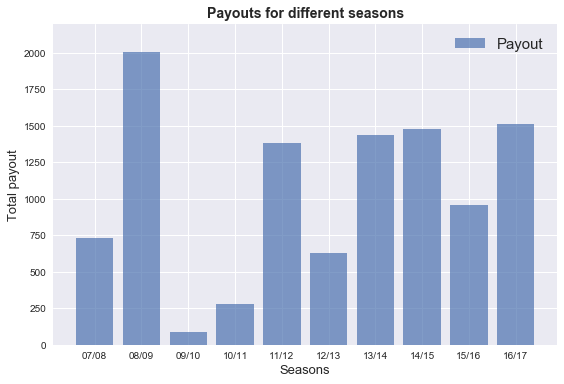

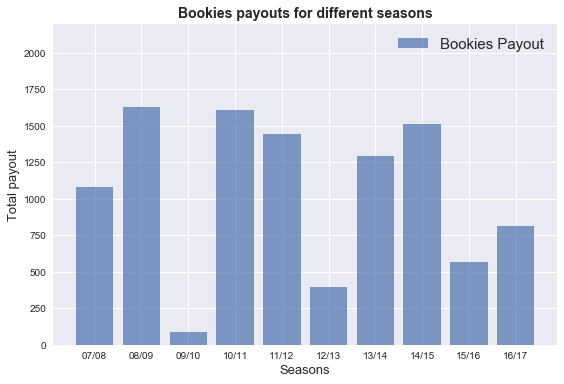

In [103]:
payouts = []
bookies_payouts = []
x = 1000

for i in range(708,1718,101):
    if i < 1011:
        simu = simulate('0'+str(i),x)
        payouts.append(simu[0])
        bookies_payouts.append(simu[1])
    else:
        simu = simulate(str(i),x)
        payouts.append(simu[0])
        bookies_payouts.append(simu[1])

print("Total payout over 10 seasons is: {}".format(np.sum(payouts)-(x*len(payouts))))
print("This is {}%".format(((np.sum(payouts)-(x*len(payouts)))*100)/(x*len(payouts))))

print("Total bookies payout over 10 seasons is: {}".format(np.sum(bookies_payouts)-(x*len(bookies_payouts))))
print("This is {}%".format(((np.sum(bookies_payouts)-(x*len(bookies_payouts)))*100)/(x*len(bookies_payouts))))

x = np.arange(10)
plt.bar(x, height= payouts, label='Payout', alpha=0.7)
plt.xticks(x, ['07/08','08/09','09/10','10/11','11/12','12/13','13/14','14/15','15/16','16/17']);
plt.legend(loc='upper right', fontsize=15)
plt.xlabel("Seasons",size=13)
plt.ylabel("Total payout",size=13)
plt.title("Payouts for different seasons",size=14,fontweight='bold')
plt.tight_layout()
plt.ylim(0,2200)
plt.show()

x = np.arange(10)
plt.bar(x, height= bookies_payouts, label='Bookies Payout', alpha=0.7)
plt.xticks(x, ['07/08','08/09','09/10','10/11','11/12','12/13','13/14','14/15','15/16','16/17']);
plt.legend(loc='upper right', fontsize=15)
plt.xlabel("Seasons",size=13)
plt.ylabel("Total payout",size=13)
plt.title("Bookies payouts for different seasons",size=14,fontweight='bold')
plt.tight_layout()
plt.ylim(0,2200)
plt.show()


## Simulation of the last 15 games of each season in the last 10 years

In [104]:
def simulate2(season, x):
    
    epl = pd.read_csv("http://www.football-data.co.uk/mmz4281/{}/E0.csv".format(season))
    epl = epl[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR', 'B365H', 'B365A']]
    epl = epl.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals' , 'FTR' : 'Winner'})
    goal_model_data = pd.concat([epl[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

    poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                            family=sm.families.Poisson()).fit()
    
    epl_matches = epl[['HomeTeam','AwayTeam']]
    epl_matches = epl_matches[-20:]
    epl_winner = epl[['Winner']]
    epl_odds = epl[['B365H', 'B365A']]

    #model lists
    bets = []
    results = []
    odds = []
    
    #bookies litst
    bookies_bets = []
    bookies_results = []
    bookies_odds = []
    
    #initial values
    payout = 0
    bookies_payout = 0
    model_wins = 0
    bookies_wins = 0
    
    for i in range(361,380):
        matrix = simulate_match(poisson_model, epl_matches['HomeTeam'][i], epl_matches['AwayTeam'][i], max_goals=10)
        home_win = np.sum(np.tril(matrix, -1))
        draw = np.sum(np.diag(matrix))
        away_win = np.sum(np.triu(matrix, 1))
        if home_win > 0.55:
            bets.append('H')
            results.append(epl_winner['Winner'][i])
            odds.append((float)(epl_odds['B365H'][i]))
        elif away_win > 0.55:
            bets.append('A')
            results.append(epl_winner['Winner'][i])
            odds.append((float)(epl_odds['B365A'][i]))
        if 1/epl_odds['B365H'][i] > 0.55:
            bookies_bets.append('H')
            bookies_results.append(epl_winner['Winner'][i])
            bookies_odds.append((float)(epl_odds['B365H'][i]))
        elif 1/epl_odds['B365A'][i] > 0.55:
            bookies_bets.append('A')
            bookies_results.append(epl_winner['Winner'][i])
            bookies_odds.append((float)(epl_odds['B365A'][i]))

    for k in range(0, len(bets)):
        if bets[k] == results[k]:
            payout += (odds[k]*(x/len(bets)))
        else:
            payout -= x/len(bets)
            
    for m in range(0, len(bookies_bets)):       
        if bookies_bets[m] == bookies_results[m]:
            bookies_payout += (bookies_odds[m]*(x/len(bookies_bets)))
        else:
            bookies_payout -= x/len(bookies_bets)
        
    
    return [payout, bookies_payout]

Total payout over 10 seasons is: -687.7777777777774
This is -6.877777777777774%
Total bookies payout over 10 seasons is: -868.6295093795088
This is -8.686295093795088%


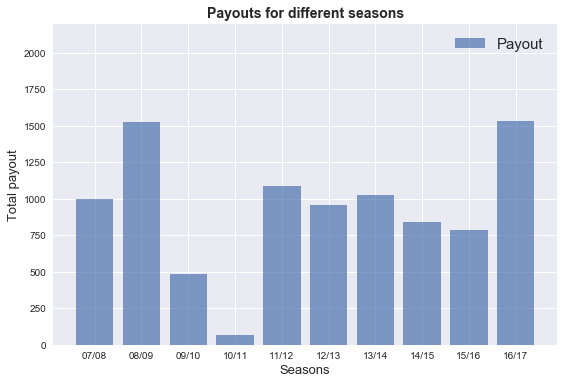

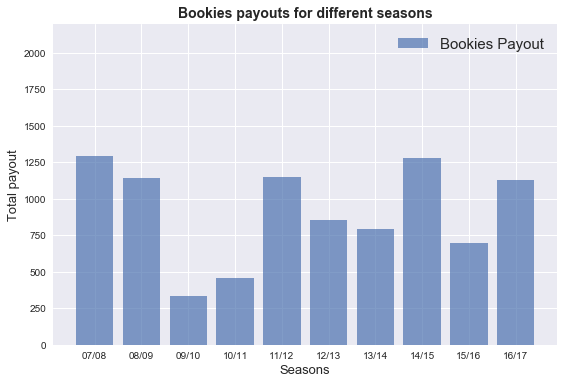

In [105]:
payouts = []
bookies_payouts = []
x = 1000

for i in range(708,1718,101):
    if i < 1011:
        simu = simulate2('0'+str(i),x)
        payouts.append(simu[0])
        bookies_payouts.append(simu[1])
    else:
        simu = simulate2(str(i),x)
        payouts.append(simu[0])
        bookies_payouts.append(simu[1])

print("Total payout over 10 seasons is: {}".format(np.sum(payouts)-(x*len(payouts))))
print("This is {}%".format(((np.sum(payouts)-(x*len(payouts)))*100)/(x*len(payouts))))

print("Total bookies payout over 10 seasons is: {}".format(np.sum(bookies_payouts)-(x*len(bookies_payouts))))
print("This is {}%".format(((np.sum(bookies_payouts)-(x*len(bookies_payouts)))*100)/(x*len(bookies_payouts))))

x = np.arange(10)
plt.bar(x, height= payouts, label='Payout', alpha=0.7)
plt.xticks(x, ['07/08','08/09','09/10','10/11','11/12','12/13','13/14','14/15','15/16','16/17']);
plt.legend(loc='upper right', fontsize=15)
plt.xlabel("Seasons",size=13)
plt.ylabel("Total payout",size=13)
plt.title("Payouts for different seasons",size=14,fontweight='bold')
plt.tight_layout()
plt.ylim(0,2200)
plt.show()

x = np.arange(10)
plt.bar(x, height= bookies_payouts, label='Bookies Payout', alpha=0.7)
plt.xticks(x, ['07/08','08/09','09/10','10/11','11/12','12/13','13/14','14/15','15/16','16/17']);
plt.legend(loc='upper right', fontsize=15)
plt.xlabel("Seasons",size=13)
plt.ylabel("Total payout",size=13)
plt.title("Bookies payouts for different seasons",size=14,fontweight='bold')
plt.tight_layout()
plt.ylim(0,2200)
plt.show()

## Simulate last 5 games

In [106]:
def simulate3(season, x):
    
    epl = pd.read_csv("http://www.football-data.co.uk/mmz4281/{}/E0.csv".format(season))
    epl = epl[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR', 'B365H', 'B365A']]
    epl = epl.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals' , 'FTR' : 'Winner'})
    goal_model_data = pd.concat([epl[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

    poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                            family=sm.families.Poisson()).fit()
    
    epl_matches = epl[['HomeTeam','AwayTeam']]
    epl_matches = epl_matches[-5:]
    epl_winner = epl[['Winner']]
    epl_odds = epl[['B365H', 'B365A']]

    #model lists
    bets = []
    results = []
    odds = []
    
    #bookies litst
    bookies_bets = []
    bookies_results = []
    bookies_odds = []
    
    #initial values
    payout = 0
    bookies_payout = 0
    model_wins = 0
    bookies_wins = 0
    
    for i in range(376,380):
        matrix = simulate_match(poisson_model, epl_matches['HomeTeam'][i], epl_matches['AwayTeam'][i], max_goals=10)
        home_win = np.sum(np.tril(matrix, -1))
        draw = np.sum(np.diag(matrix))
        away_win = np.sum(np.triu(matrix, 1))
        if home_win > 0.55:
            bets.append('H')
            results.append(epl_winner['Winner'][i])
            odds.append((float)(epl_odds['B365H'][i]))
        elif away_win > 0.55:
            bets.append('A')
            results.append(epl_winner['Winner'][i])
            odds.append((float)(epl_odds['B365A'][i]))
        if 1/epl_odds['B365H'][i] > 0.55:
            bookies_bets.append('H')
            bookies_results.append(epl_winner['Winner'][i])
            bookies_odds.append((float)(epl_odds['B365H'][i]))
        elif 1/epl_odds['B365A'][i] > 0.55:
            bookies_bets.append('A')
            bookies_results.append(epl_winner['Winner'][i])
            bookies_odds.append((float)(epl_odds['B365A'][i]))

    for k in range(0, len(bets)):
        if bets[k] == results[k]:
            payout += (odds[k]*(x/len(bets)))
        else:
            payout -= x/len(bets)
            
    for m in range(0, len(bookies_bets)):       
        if bookies_bets[m] == bookies_results[m]:
            bookies_payout += (bookies_odds[m]*(x/len(bookies_bets)))
        else:
            bookies_payout -= x/len(bookies_bets)
        
    
    return [payout, bookies_payout]

Total payout over 10 seasons is: 2611.666666666666
This is 26.11666666666666%
Total bookies payout over 10 seasons is: 1431.666666666666
This is 14.31666666666666%


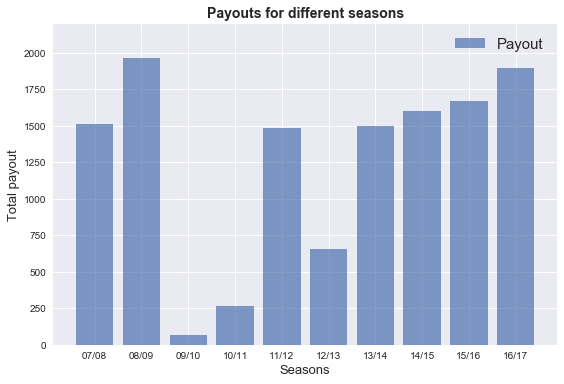

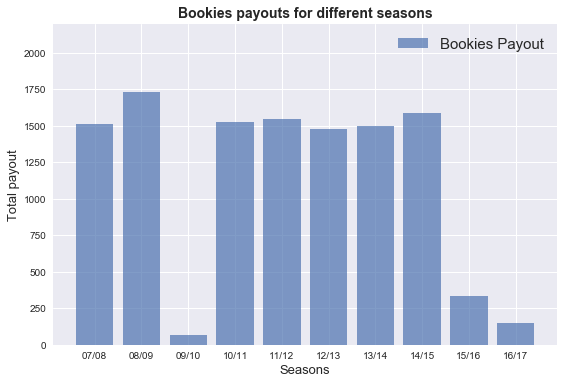

In [107]:
payouts = []
bookies_payouts = []
x = 1000

for i in range(708,1718,101):
    if i < 1011:
        simu = simulate3('0'+str(i),x)
        payouts.append(simu[0])
        bookies_payouts.append(simu[1])
    else:
        simu = simulate3(str(i),x)
        payouts.append(simu[0])
        bookies_payouts.append(simu[1])

print("Total payout over 10 seasons is: {}".format(np.sum(payouts)-(x*len(payouts))))
print("This is {}%".format(((np.sum(payouts)-(x*len(payouts)))*100)/(x*len(payouts))))

print("Total bookies payout over 10 seasons is: {}".format(np.sum(bookies_payouts)-(x*len(bookies_payouts))))
print("This is {}%".format(((np.sum(bookies_payouts)-(x*len(bookies_payouts)))*100)/(x*len(bookies_payouts))))

x = np.arange(10)
plt.bar(x, height= payouts, label='Payout', alpha=0.7)
plt.xticks(x, ['07/08','08/09','09/10','10/11','11/12','12/13','13/14','14/15','15/16','16/17']);
plt.legend(loc='upper right', fontsize=15)
plt.xlabel("Seasons",size=13)
plt.ylabel("Total payout",size=13)
plt.title("Payouts for different seasons",size=14,fontweight='bold')
plt.tight_layout()
plt.ylim(0,2200)
plt.show()

x = np.arange(10)
plt.bar(x, height= bookies_payouts, label='Bookies Payout', alpha=0.7)
plt.xticks(x, ['07/08','08/09','09/10','10/11','11/12','12/13','13/14','14/15','15/16','16/17']);
plt.legend(loc='upper right', fontsize=15)
plt.xlabel("Seasons",size=13)
plt.ylabel("Total payout",size=13)
plt.title("Bookies payouts for different seasons",size=14,fontweight='bold')
plt.tight_layout()
plt.ylim(0,2200)
plt.show()

## Model Prediction Compared To Bookies Prediction

In the following simulations I will make the bookies bet every time the model wants to bet

In [112]:
def simulate4(season, x):
    
    epl = pd.read_csv("http://www.football-data.co.uk/mmz4281/{}/E0.csv".format(season))
    epl = epl[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR', 'B365H', 'B365A']]
    epl = epl.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals' , 'FTR' : 'Winner'})
    goal_model_data = pd.concat([epl[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

    poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                            family=sm.families.Poisson()).fit()
    
    epl_matches = epl[['HomeTeam','AwayTeam']]
    epl_matches = epl_matches[-10:]
    epl_winner = epl[['Winner']]
    epl_odds = epl[['B365H', 'B365A']]

    #model lists
    bets = []
    results = []
    odds = []
    
    #bookies litst
    bookies_bets = []
    bookies_results = []
    bookies_odds = []
    
    #initial values
    payout = 0
    bookies_payout = 0
    model_wins = 0
    bookies_wins = 0
    
    for i in range(371,380):
        matrix = simulate_match(poisson_model, epl_matches['HomeTeam'][i], epl_matches['AwayTeam'][i], max_goals=10)
        home_win = np.sum(np.tril(matrix, -1))
        draw = np.sum(np.diag(matrix))
        away_win = np.sum(np.triu(matrix, 1))
        if home_win > 0.55:
            bets.append('H')
            results.append(epl_winner['Winner'][i])
            odds.append((float)(epl_odds['B365H'][i]))
            if (1/epl_odds['B365H'][i]) > (1/epl_odds['B365A'][i]):
                bookies_bets.append('H')
                bookies_results.append(epl_winner['Winner'][i])
                bookies_odds.append((float)(epl_odds['B365H'][i]))
            else:
                bookies_bets.append('A')
                bookies_results.append(epl_winner['Winner'][i])
                bookies_odds.append((float)(epl_odds['B365A'][i]))
            '''if ((1/epl_odds['B365H'][i]) < (1/epl_odds['B365A'][i]) and epl_winner['Winner'][i] == 'H'):
                model_wins += 1
            if ((1/epl_odds['B365H'][i]) < (1/epl_odds['B365A'][i]) and epl_winner['Winner'][i] == 'A'):  
                bookies_wins += 1 '''
        elif away_win > 0.55:
            bets.append('A')
            results.append(epl_winner['Winner'][i])
            odds.append((float)(epl_odds['B365A'][i]))
            if epl_odds['B365H'][i] > epl_odds['B365A'][i]:
                bookies_bets.append('H')
                bookies_results.append(epl_winner['Winner'][i])
                bookies_odds.append((float)(epl_odds['B365H'][i]))
            else:
                bookies_bets.append('A')
                bookies_results.append(epl_winner['Winner'][i])
                bookies_odds.append((float)(epl_odds['B365A'][i]))
            '''if ((1/epl_odds['B365H'][i]) > (1/epl_odds['B365A'][i]) and epl_winner['Winner'][i] == 'A'):
                model_wins += 1
            if ((1/epl_odds['B365H'][i]) > (1/epl_odds['B365A'][i]) and epl_winner['Winner'][i] == 'H'):
                bookies_wins += 1'''

    for k in range(0, len(bets)):
        if bets[k] == results[k]:
            payout += (odds[k]*(x/len(bets)))
            if bookies_bets[k] != results[k]:
                model_wins += 1
        elif bets[k] != results[k]:
            payout -= x/len(bets)
            if bookies_bets[k] == results[k]:
                bookies_wins += 1
        if bookies_bets[k] == bookies_results[k]:
            bookies_payout += (bookies_odds[k]*(x/len(bookies_bets)))
        elif bookies_bets[k] != bookies_results[k]:
            bookies_payout -= x/len(bookies_bets)
        
        
    print(season)
    print("Model bets: {}".format(bets))
    print("Actual results: {}".format(results))
    print("Model predicted right outcome when Bookies predicted wrong outcome in season {}: {}".format(season,model_wins))
    print("Bookies bets: {}".format(bookies_bets))
    print("Actual results: {}".format(bookies_results))
    print("Bookies predicted right outcome when Model predicted wrong outcome in season {}: {}".format(season,bookies_wins))
    
    return [payout, bookies_payout]

0708
Model bets: ['H', 'A', 'H', 'H', 'A', 'A']
Actual results: ['D', 'A', 'H', 'A', 'A', 'A']
Model predicted right outcome when Bookies predicted wrong outcome in season 0708: 3
Bookies bets: ['H', 'H', 'H', 'A', 'H', 'H']
Actual results: ['D', 'A', 'H', 'A', 'A', 'A']
Bookies predicted right outcome when Model predicted wrong outcome in season 0708: 1
0809
Model bets: ['H', 'A', 'H', 'H', 'A', 'H']
Actual results: ['H', 'A', 'H', 'H', 'A', 'H']
Model predicted right outcome when Bookies predicted wrong outcome in season 0809: 2
Bookies bets: ['H', 'H', 'H', 'H', 'H', 'H']
Actual results: ['H', 'A', 'H', 'H', 'A', 'H']
Bookies predicted right outcome when Model predicted wrong outcome in season 0809: 0
0910
Model bets: ['H', 'A', 'H', 'H', 'A', 'H']
Actual results: ['A', 'H', 'H', 'H', 'D', 'H']
Model predicted right outcome when Bookies predicted wrong outcome in season 0910: 0
Bookies bets: ['H', 'H', 'H', 'H', 'H', 'H']
Actual results: ['A', 'H', 'H', 'H', 'D', 'H']
Bookies predic

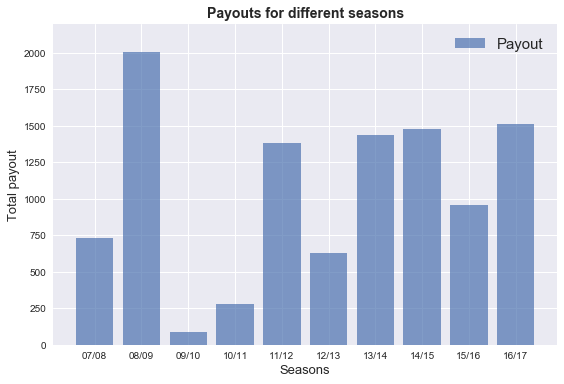

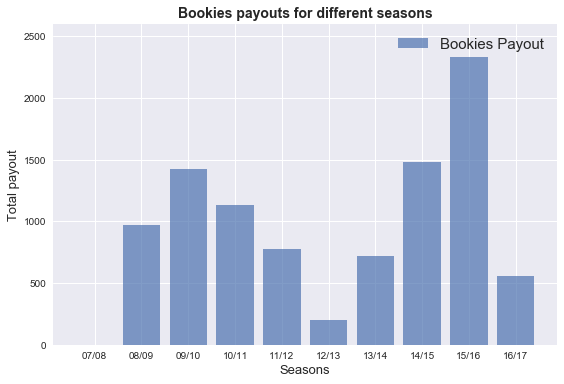

In [113]:
payouts = []
bookies_payouts = []
x = 1000

for i in range(708,1718,101):
    if i < 1011:
        simu = simulate4('0'+str(i),x)
        payouts.append(simu[0])
        bookies_payouts.append(simu[1])
    else:
        simu = simulate4(str(i),x)
        payouts.append(simu[0])
        bookies_payouts.append(simu[1])

print("Total payout over 10 seasons is: {}".format(np.sum(payouts)-(x*len(payouts))))
print("This is {}%".format(((np.sum(payouts)-(x*len(payouts)))*100)/(x*len(payouts))))

print("Total bookies payout over 10 seasons is: {}".format(np.sum(bookies_payouts)-(x*len(bookies_payouts))))
print("This is {}%".format(((np.sum(bookies_payouts)-(x*len(bookies_payouts)))*100)/(x*len(bookies_payouts))))

x = np.arange(10)
plt.bar(x, height= payouts, label='Payout', alpha=0.7)
plt.xticks(x, ['07/08','08/09','09/10','10/11','11/12','12/13','13/14','14/15','15/16','16/17']);
plt.legend(loc='upper right', fontsize=15)
plt.xlabel("Seasons",size=13)
plt.ylabel("Total payout",size=13)
plt.title("Payouts for different seasons",size=14,fontweight='bold')
plt.tight_layout()
plt.ylim(0,2200)
plt.show()

x = np.arange(10)
plt.bar(x, height= bookies_payouts, label='Bookies Payout', alpha=0.7)
plt.xticks(x, ['07/08','08/09','09/10','10/11','11/12','12/13','13/14','14/15','15/16','16/17']);
plt.legend(loc='upper right', fontsize=15)
plt.xlabel("Seasons",size=13)
plt.ylabel("Total payout",size=13)
plt.title("Bookies payouts for different seasons",size=14,fontweight='bold')
plt.tight_layout()
plt.ylim(0,2600)
plt.show()